In [1]:
#LSTM caso 1: UNIVARIADO - CANTIDAD_VENTAS
import pyodbc
import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM
from keras.optimizers import SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

plt.rcParams['figure.figsize' ] = (16, 9)
plt.style.use('fast')

In [2]:
# sql_server = """
# DRIVER={ODBC Driver 17 for SQL Server};
# server=192.168.1.235,1433;
# database=demo_prediccion;
# uid=sa;
# pwd=qwerty;
# Trusted_connection=yes;
# """

In [3]:
sql_server = """
DRIVER={ODBC Driver 17 for SQL Server};
server=192.168.1.235,1433;
database=AdventureWorksDW2022;
uid=sa;
pwd=qwerty;
Trusted_connection=yes;
"""

In [4]:
# Se entrenará con todos los datos de las ventas menores al 2020
# query = """
# SELECT
# [F].[Fecha] AS fecha,
# SUM([H]. [cantidad]) AS TotalVentas
# FROM
# [demo_prediccion]. [dbo]. [hechos] AS [H]
# INNER JOIN [demo_prediccion]. [dbo]. [Dim_fechas] AS [f] ON [H].[id_DimFechas] = [F].[id]
# WHERE 
# [F].[Fecha] > '2016-12-31' AND [F].[Fecha] < '2020-01-01'
# GROUP BY [F].[Fecha]
# ORDER BY [F].[Fecha]
# """

In [5]:
query = """
SELECT CAST(f.OrderDate AS DATE) AS sales_date, CAST(SUM(f.SalesAmount) AS INT) AS TotalVentas FROM FactInternetSales AS f WHERE F.OrderDate < '2012-01-01' GROUP BY CAST(f.OrderDate AS DATE) ORDER BY CAST(f.OrderDate AS DATE) ASC;
"""

In [6]:
# query2="""
# SELECT
# [F].[Fecha] AS fecha,
# SUM([H]. [cantidad]) AS TotalVentas
# FROM
# [demo_prediccion]. [dbo]. [hechos] AS [H]
# INNER JOIN [demo_prediccion]. [dbo]. [Dim_fechas] AS [f] ON [H].[id_DimFechas] = [F].[id]
# WHERE 
# [F].[Fecha] > '2016-12-31' AND [F].[Fecha] < '2021-01-01'
# GROUP BY [F].[Fecha]
# ORDER BY [F].[Fecha]
# """

In [7]:
query2 = """
SELECT CAST(f.OrderDate AS DATE) AS sales_date, CAST(SUM(f.SalesAmount) AS INT) AS TotalVentas FROM FactInternetSales AS f GROUP BY CAST(f.OrderDate AS DATE) ORDER BY CAST(f.OrderDate AS DATE) ASC;
"""

In [8]:
#CONSTANTES

PASOS = 31
TRAINING_PERCENTAGE = 0.8
N_PREDICTIONS = 31
EPOCHS = 100
NEURONS = 31 #Mismo que el de pasos


#NOTAS DE ESTA PARTE: el número de pasos no es correlativo al No. de predicciones
#ya que, las predicciones pudieran ser de 61 días y el No. de pasos siempre serán 31, ya que bajo
#ese proceso se hizo el entrenamiento

In [9]:
#Opcion 1: Permitir que pueda ser modificada la sentencia, y mantener el try para evitar de que
# el programa se rompa
def get_sqlconnection(config_sqlServer):
    status = "inicializando...."
    try: 
        connection = pyodbc.connect(sql_server)
        status = "Conexion establecida satisfactoriamente"
    except Exception as e:
        status = "Error al establecer la conexión:"+e
    print(status)
    return connection

In [10]:
def set_index_datetime(data):
        if str(type(data) == "<class 'pandas.core.frame.DataFrame'>"):
            # data.sort_values('fecha', inplace=True)
            for column in data.columns: 
                try: 
                    pd.to_datetime(data[column])
                    data.set_index(column,inplace=True)
                    return data
                except Exception as e:  
                    pass
        else: 
            return 0

In [11]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
def create_x_y_train(data):
    values = data.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values= values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    values = reframed.values
    
    #debemos obtener el total de datos de entrenamiento
    n_train_days = int(len(values) * TRAINING_PERCENTAGE)
    print("Total de datos: ",int(len(values)))

    #80% - entrenamiento 
    train = values[:n_train_days, :]
    print("entrenamiento: ",len(train))

    #20% - prueba
    test = values[n_train_days:, :]
    print("testing: ",len(test))
    x_train, y_train = train[:, :- 1], train[:, -1]
    x_val, y_val = test[:, :- 1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], PASOS, 1))
    x_val = x_val.reshape((x_val.shape[0], PASOS,1))
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    return x_train, y_train, x_val, y_val, scaler, values

In [13]:
def train_model(x_train, y_train, x_val, y_val, scaler, values, data, model):
    history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(x_val, y_val), verbose=2, shuffle=False)

    #Obtener el 20% de la data
    ultimosDias = data[data.index[int(len(data)*TRAINING_PERCENTAGE)]:]
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[PASOS]], axis=1, inplace=True)
    values = reframed.values
    print("Meses registrados: ",len(values))
    x_test = values[len(values)-1:, :]
    print("La cantidad de días son: ",x_test.size)
    print("Dimensiones de x_test antes del reshape:", x_test.shape)
    #Tensor
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    return model, x_test

In [14]:
def crear_modeloLSTM():
    input_shape = (PASOS,1)
    model = Sequential()
    model.add(LSTM(NEURONS, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])
    return model

In [15]:
def eliminar_anomalias(dtaframe):
    dataFrame_anomalias = dtaframe.copy()
    modeloIsolation = IsolationForest(contamination=0.05)
    modeloIsolation.fit(dataFrame_anomalias)
    anomalias = modeloIsolation.predict(dataFrame_anomalias)
    dtaframe['anomalias' ] = anomalias
    dataFrameSinAnomalias = dtaframe[dtaframe['anomalias' ] != -1]
    dataFrameSinAnomalias = dataFrameSinAnomalias.drop('anomalias', axis=1)
    return dataFrameSinAnomalias

In [16]:
def addNewValue(x_test, nuevoValor):
    x_test[0, :-1, 0] = x_test[0, 1:, 0]
    x_test[0, -1, 0] = nuevoValor
    return x_test

In [17]:
#core
with get_sqlconnection(sql_server) as cursor: 
    prepData = pd.read_sql_query(query,cursor)
    historyData = pd.read_sql_query(query2, cursor)

    

Conexion establecida satisfactoriamente


C:\Users\JoCel\AppData\Local\Temp\ipykernel_7124\1245306699.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prepData = pd.read_sql_query(query,cursor)
C:\Users\JoCel\AppData\Local\Temp\ipykernel_7124\1245306699.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  historyData = pd.read_sql_query(query2, cursor)


In [18]:
    prepData

,sales_date,TotalVentas
0,2010-12-29,14477
1,2010-12-30,13932
2,2010-12-31,15012
3,2011-01-01,7157
4,2011-01-02,15012
...,...,...
360,2011-12-27,28220
361,2011-12-28,18234
362,2011-12-29,14498
363,2011-12-30,3965


In [19]:
    prepData = set_index_datetime(prepData)
    historyData = set_index_datetime(historyData)

In [20]:
    #Switch the format on days or months
    #nota, acualmente los datos son filtrados con respecto a solo si son en  formato de día o de mes,
    #en LSTM, que incluye  datos en horarios, se tendría que modificar esta parte
    first_day = prepData.index.min() + timedelta(days=1)
    last_day = prepData.index.max() + timedelta(days=1)
    future_days = [last_day + timedelta(days=i) for i in range(N_PREDICTIONS)]
    for i in range(len(future_days)):
        future_days[i] = str(future_days[i])[:10]

In [21]:
    #De momento solamente será la fecha
    future_data = pd.DataFrame(future_days, columns=['fecha'])
    
    #creamos un modelo
    model = crear_modeloLSTM()
    for column in prepData.columns:
        # data = prepData.filter([column])
        data = prepData.filter([column])
        data.set_index(prepData.index, inplace=True)
        data = eliminar_anomalias(data)
        x_train, y_train, x_val, y_val, scaler, values = create_x_y_train(data)
        model, x_test = train_model(x_train, y_train,x_val, y_val,scaler, values, data, model)
        copy_test = x_test

c:\GitHub\pronostico\pronostico\envprediccion\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Total de datos:  315
entrenamiento:  252
testing:  63
(252, 31, 1) (252,) (63, 31, 1) (63,)
Epoch 1/100
8/8 - 2s - 223ms/step - loss: 0.4401 - mse: 0.2765 - val_loss: 0.4184 - val_mse: 0.2692
Epoch 2/100
8/8 - 0s - 16ms/step - loss: 0.3946 - mse: 0.2263 - val_loss: 0.4159 - val_mse: 0.2754
Epoch 3/100
8/8 - 0s - 14ms/step - loss: 0.3727 - mse: 0.2038 - val_loss: 0.4224 - val_mse: 0.2931
Epoch 4/100
8/8 - 0s - 13ms/step - loss: 0.3654 - mse: 0.2039 - val_loss: 0.4287 - val_mse: 0.3093
Epoch 5/100
8/8 - 0s - 16ms/step - loss: 0.3703 - mse: 0.2086 - val_loss: 0.4262 - val_mse: 0.3023
Epoch 6/100
8/8 - 0s - 13ms/step - loss: 0.3682 - mse: 0.2037 - val_loss: 0.4236 - val_mse: 0.2957
Epoch 7/100
8/8 - 0s - 14ms/step - loss: 0.3654 - mse: 0.2017 - val_loss: 0.4238 - val_mse: 0.2963
Epoch 8/100
8/8 - 0s - 14ms/step - loss: 0.3655 - mse: 0.2006 - val_loss: 0.4256 - val_mse: 0.3009
Epoch 9/100
8/8 - 0s - 15ms/step - loss: 0.3633 - mse: 0.2006 - val_loss: 0.4258 - val_mse: 0.3015
Epoch 10/100
8/8

In [22]:
        results = []
        for i in range(N_PREDICTIONS):
            parcial = model.predict(x_test)
            results.append(parcial[0])
            x_test = addNewValue(x_test,parcial[0])
        adimen = np.array(results).reshape(-1, 1)
        inverted = scaler.inverse_transform(adimen)
        future_data[column] = inverted.astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\JoCel\AppData\Local\Temp\ipykernel_7124\259943522.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0, -1, 0] = nuevoValor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

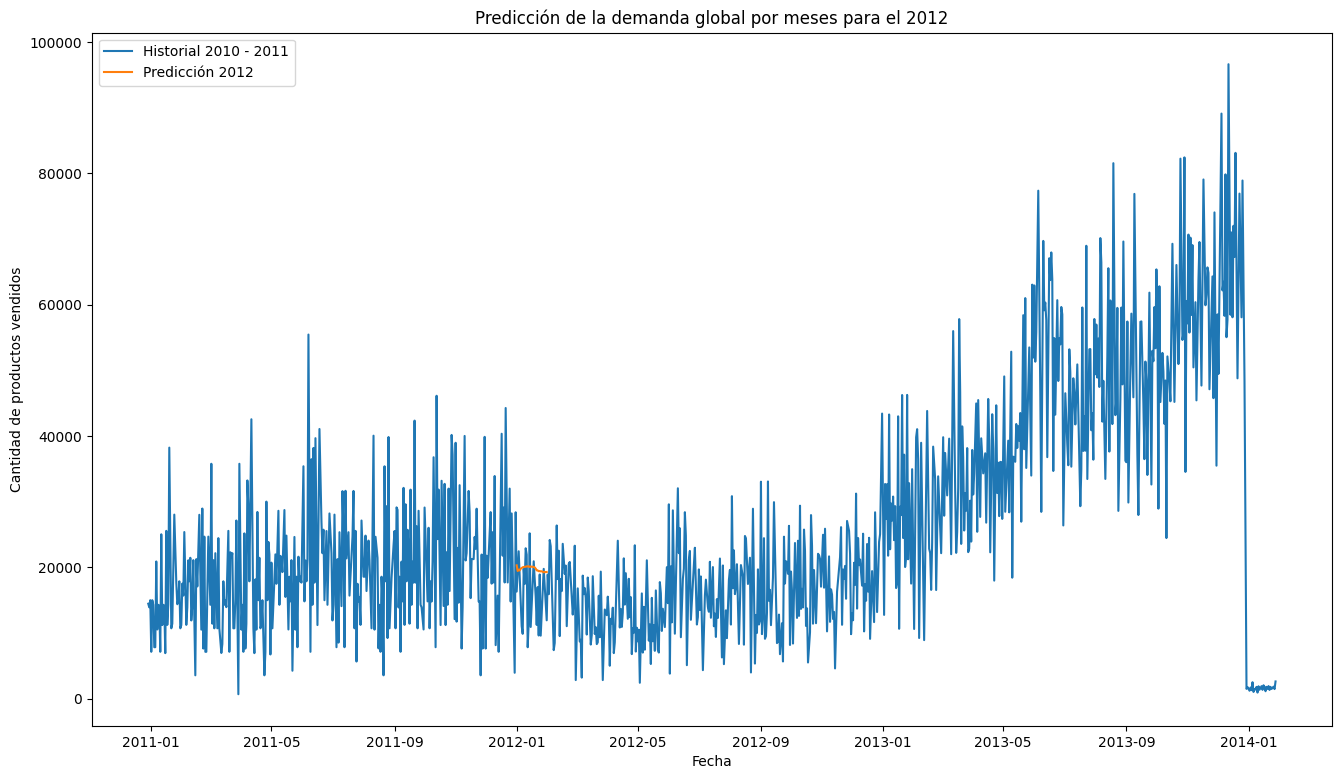

In [23]:
    future_data = set_index_datetime(future_data)
    prepData = historyData
    prepData.index = pd.to_datetime(historyData.index)
    future_data.index = pd.to_datetime(future_data.index)
    plt.plot(prepData.index, prepData['TotalVentas'],label='Historial {p0} - {p1}'.format(p0=str(first_day.year), p1= str(last_day.year-1)))
    plt.plot(future_data.index, future_data['TotalVentas'],label='Predicción {p0}'.format(p0=str(last_day.year)))
    xtics = data.index.union(future_data.index)[::10]

    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de productos vendidos')
    plt.title('Predicción de la demanda global por meses para el {p0}'.format(p0=str(last_day.year)))



    plt.legend()
    plt.show()

In [24]:
    future_data

,TotalVentas
fecha,
2012-01-01,20321
2012-01-02,19461
2012-01-03,19653
2012-01-04,19540
2012-01-05,19827
2012-01-06,19902
2012-01-07,20024
2012-01-08,20063
2012-01-09,20100
